<a href="https://colab.research.google.com/github/VARSHITHAGANJI/EP4130/blob/main/DSA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DSA Project


In [ ]:

!pip install pymc3
!pip install theano-pymc
import pandas as pd

seasons_string = ["PL08-09", "PL09-10", "PL10-11", "PL11-12",
                  "PL12-13", "PL13-14", "PL14-15", "PL15-16", "PL16-17"]

df = pd.read_csv(seasons_string[0]+".csv")

for i in range(1,len(seasons_string)):
  df_temp = pd.read_csv(seasons_string[i]+".csv")
  df = pd.concat([df,df_temp])

df.head(10)



df = df.rename(
    columns={
        "HomeTeam": "home_team",
        "AwayTeam": "away_team",
        "FTHG": "yg1",
        "FTAG": "yg2",
        "FTR": "result"
    }
)

df_data = df[["Date", "home_team", "away_team", "yg1", "yg2", "result"]]
df_data.head(10)

In [44]:
import numpy as np

n_teams = len(df_data["home_team"].unique())

teams = (
    df_data[["home_team"]]
    .drop_duplicates()
    .sort_values("home_team")
    .reset_index(drop=True)
    .assign(team_index=np.arange(n_teams))
    .rename(columns={"home_team": "team"})
)

df_final = (
    df_data.merge(teams, left_on="home_team", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .merge(teams, left_on="away_team", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("Date")
)

df_final.head()

,Date,home_team,away_team,yg1,yg2,result,hg,ag
1820,01/01/11,Tottenham,Fulham,1,0,H,28,12
830,01/01/11,West Brom,Man United,1,2,A,30,17
2656,01/01/11,Man City,Blackpool,1,0,H,16,4
3384,01/01/11,Birmingham,Arsenal,0,3,A,2,0
1389,01/01/11,Liverpool,Bolton,2,1,H,15,5


In [45]:
TEST_SIZE = 300
train = df_final.iloc[:-TEST_SIZE]
test = df_final.iloc[-TEST_SIZE:]

goals_home_obs = train["yg1"].values
goals_away_obs = train["yg2"].values
home_team = train["hg"].values
away_team = train["ag"].values

In [ ]:
# !pip install pymc==4.1.4

In [46]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import pymc3 as pm
from theano import tensor as tt
import theano.tensor as tt
# import pytensor.tensor as pt
with pm.Model() as model:
    # home advantage
    home = pm.Flat("home")

    # attack ratings
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence ratings
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # apply sum zero constraints
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # calulate theta
    home_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(atts[away_team] + defs[home_team])

    # goal expectation
    home_points = pm.Poisson("home_goals", mu=home_theta, observed=goals_home_obs)
    away_points = pm.Poisson("away_goals", mu=away_theta, observed=goals_away_obs)

In [47]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

In [56]:
CI_home= az.stats.hdi(trace["home"])
home_mean= np.mean(trace['home'])
median_home = np.quantile(trace["home"], 0.5, axis=0)
home_25 = np.quantile(trace["home"], 0.025, axis=0)
home_97 = np.quantile(trace["home"], 0.975, axis=0)
home_summary = pd.DataFrame([[CI_home,home_mean,median_home,home_25,home_97]],columns = ['HDI','mean','median','2.5%','97.5%'])
home_summary

,HDI,mean,median,2.5%,97.5%
0,"[0.3293331582283308, 0.3961449369824964]",0.362143,0.361959,0.327349,0.397469


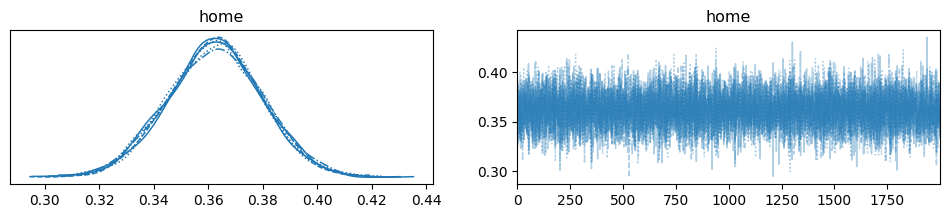

In [34]:
with model:
    pm.plot_trace(trace, var_names=["home"]);

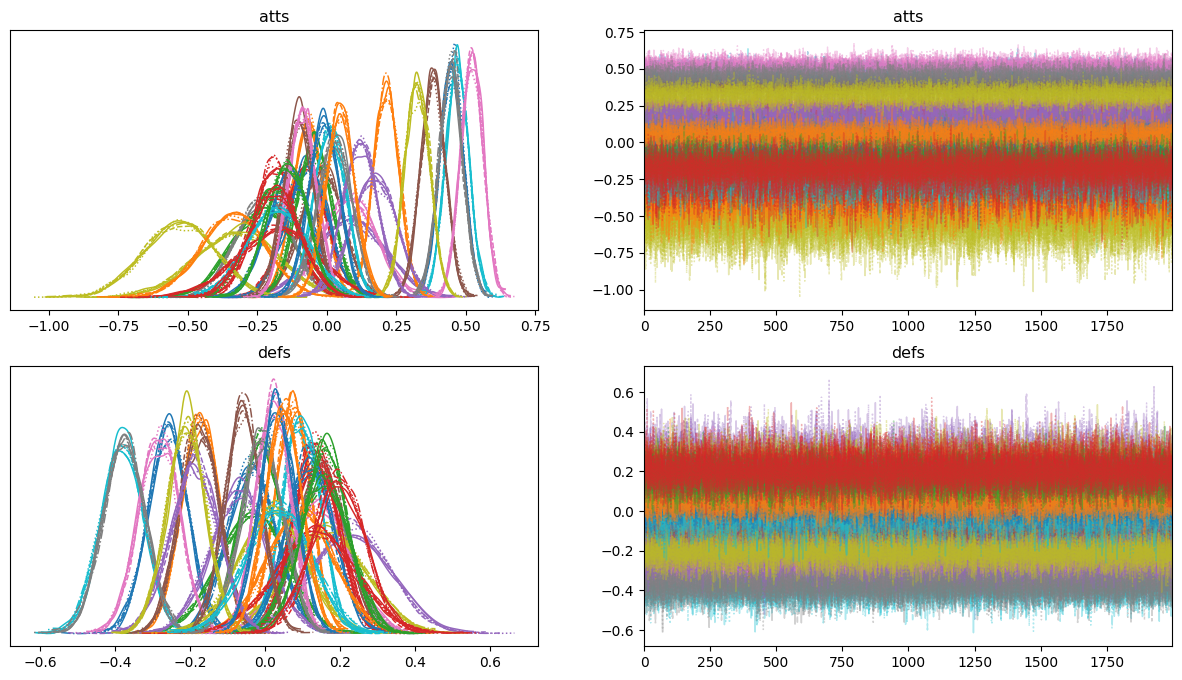

In [42]:
with model:
    pm.plot_trace(trace, var_names=["atts", "defs"],figsize=(15,8));

<ipython-input-36-3a75c6d9509b>:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

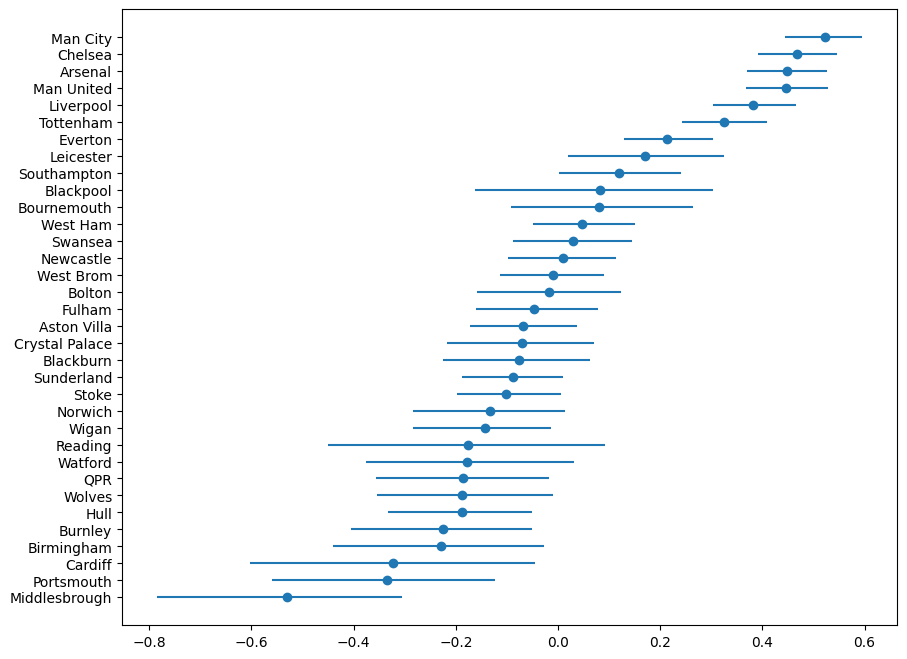

In [36]:
import arviz as az
import matplotlib.pyplot as plt

atts = (
    pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["atts"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)
plt.figure(figsize=(10,8))
plt.errorbar(
    atts["median"],
    atts["Team"],
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)

<ipython-input-37-952aaf74b74c>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

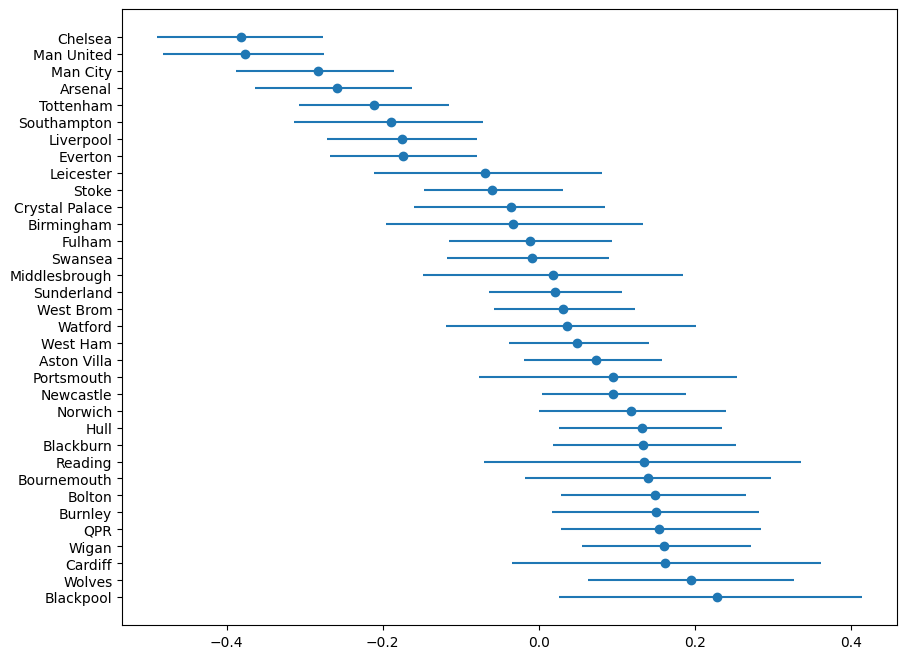

In [37]:
defs = (
    pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["defs"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=False)
)
plt.figure(figsize=(10,8))
plt.errorbar(
    defs["median"],
    defs["Team"],
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)

In [10]:
def goal_expectation(trace, home_team_id, away_team_id):
    # get parameters
    home = np.mean(trace["home"])
    atts_home = np.mean([x[home_team_id] for x in trace["atts"]])
    atts_away = np.mean([x[away_team_id] for x in trace["atts"]])
    defs_home = np.mean([x[home_team_id] for x in trace["defs"]])
    defs_away = np.mean([x[away_team_id] for x in trace["defs"]])

    # calculate theta
    home_theta = np.exp(home + atts_home + defs_away)
    away_theta = np.exp(atts_away + defs_home)

    # return the average per team
    return home_theta, away_theta

In [14]:
goal_expectation(trace, 16, 17) # goals for Man City vs Man United

(1.661834510275189, 1.1774727441500785)

In [12]:
from scipy.stats import poisson

def win_draw_loss(home_expectation, away_expectation, max_goals=10):
    h = poisson.pmf(range(max_goals+1), home_expectation)
    a = poisson.pmf(range(max_goals+1), away_expectation)
    m = np.outer(h, a)

    home = np.sum(np.tril(m, -1))
    away = np.sum(np.triu(m, 1))
    draw = np.sum(np.diag(m))

    return home, draw, away

In [22]:
def rps_i(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.zeros(len(probs))
    cum_outcomes[outcome] = 1
    cum_outcomes = np.cumsum(cum_outcomes)

    sum_rps = 0
    for i in range(len(probs)):
        sum_rps += (cum_probs[i] - cum_outcomes[i]) ** 2

    return sum_rps / (len(probs) - 1)

In [23]:
def calculate_rps(df):
    rps = list()
    for idx, row in df.iterrows():
        if row["result"] == "H":
            outcome = 0
        elif row["result"] == "D":
            outcome = 1
        elif row["result"] == "A":
            outcome = 2

        h, a = goal_expectation(trace, row["hg"], row["ag"])
        predictions = win_draw_loss(h, a)

        rps.append(rps_i(predictions, outcome))

    return np.mean(rps)

In [24]:
calculate_rps(test)

0.19896578623201105